# Select fCpGs

Run all cells to:
- Import TCGA and normal samples methylation data
- Select Clock (fCpG) sites and save
- Refine final list of tumors and save
- Calculate $c_\beta$ values and save
- Save beta values of Clock sites separately
- Generate figures relating to this site selection
- Calculate some statistics

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress, chi2_contingency
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts
import util_revision as local_util

In [2]:
## Output directories

figure_outdir = 'figures_revision'
output_dir = 'outputs_revision'

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [3]:
## Import data

# Returns list of "neutral" CpGs based on 450k and 850k array annotations
neutral_DNA_CpG_list = local_util.getNeutralDNACpGs()

# Import TCGA and normals data
data = local_util.getDataDict()

### Report purity of loyfer normals

In [ ]:
# loyfer_indir = os.path.join(consts['official_indir'], 'Loyfer')
# basal = pd.read_table(os.path.join(loyfer_indir, 'beta_values-Breast-Basal.tsv'), index_col=0)
# luminal = pd.read_table(os.path.join(loyfer_indir, 'beta_values-Breast-Luminal.tsv'), index_col=0)
# basal_LUMP = epi_util.getLUMP_values(basal)
# luminal_LUMP = epi_util.getLUMP_values(luminal)
basal_LUMP = data['basal']['purity']
luminal_LUMP = data['luminal']['purity']

display(basal_LUMP)
display(luminal_LUMP)

print(min(min(basal_LUMP), min(luminal_LUMP)))

### Output LUMP values while all the beta values are loaded

In [7]:
# Unrelated
TCGA_LUMP_values = epi_util.getLUMP_values(data['tumor']['beta_values']).rename('LUMP')
TCGA_LUMP_values.to_csv(os.path.join(consts['TCGA_datadir'], 'TCGA.LUMP_values.tsv'), sep='\t')

## Select 500 CpGs

In [11]:
# Return the Clock set of CpGs
Clock_CpGs_final_set = local_util.gen_CpG_set(data, neutral_DNA_CpG_list=None)

# Outfile path
Clock_CpGs_filepath = os.path.join(output_dir, 'Clock_CpGs.txt')

# Save Clock sites, don't overwrite existing file
if os.path.exists(Clock_CpGs_filepath):
    existing_set = np.loadtxt(Clock_CpGs_filepath, dtype=str)
    assert (np.sort(Clock_CpGs_final_set) == np.sort(existing_set)).all()
    print('Current output matches existing file.')
else:
    np.savetxt(Clock_CpGs_filepath, Clock_CpGs_final_set, fmt='%s')
    pd.Series(Clock_CpGs_final_set).to_excel(     # Also save as supplementary data file
        os.path.join(consts['repo_dir'], 'data', 'Supplementary_Data_1.xlsx'),
        index=False, header=False
    )

Selecting CpGs with 634 TCGA tumors, 4 normal basal samples, 4 normal luminal samples, 79 normal bulk samples
Starting with 482421 CpGs
Picking 500 from with 1187 resulting CpGs
Current output matches existing file.


### Chi-square test - neutral DNA CpGs

In [17]:
# Construct sets for easy and intersection and difference functions
allCpGs_set = set(data['allCpGs'])
Clock_CpGs_set = set(Clock_CpGs_final_set)
neutral_DNA_CpG_list_set = set(neutral_DNA_CpG_list)
notClock_CpGs_set = allCpGs_set.difference(Clock_CpGs_set)

# Derive counts for contingency table
n_notClock_neutral = len(notClock_CpGs_set.intersection(neutral_DNA_CpG_list_set))
n_notClock_notNeutral = len(notClock_CpGs_set.difference(neutral_DNA_CpG_list_set))

n_clock_neutral = len(Clock_CpGs_set.intersection(neutral_DNA_CpG_list_set))
n_clock_notNeutral = len(Clock_CpGs_set.difference(neutral_DNA_CpG_list_set))

# Make contingency table
observed_values = np.array(
    [
        [n_notClock_neutral, n_notClock_notNeutral],
        [n_clock_neutral, n_clock_notNeutral]
    ]
)
print('Contingency table:')
display(observed_values)

chi2, p_value, degrees_of_freedom, expected_values = chi2_contingency(observed_values)
print(f'\nChi square: P = {p_value:.0e}')

print(f'Fraction of non-Clock sites that are neutral: {n_notClock_neutral / len(notClock_CpGs_set) : .3f}')
print(f'Fraction of Clock sites that are neutral: {n_clock_neutral / len(Clock_CpGs_set) : .3f}')

odds_ratio = (observed_values[0, 1]*observed_values[1, 0]) / (observed_values[0, 0]*observed_values[1, 1])
print(f'Odds ratio: {odds_ratio:.2f}')

Contingency table:


array([[ 85961, 395960],
       [   138,    362]])


Chi square: P = 2e-08
Fraction of non-Clock sites that are neutral:  0.178
Fraction of Clock sites that are neutral:  0.276
Odds ratio: 1.76


## Remove tumors for too many missing Clock beta values

In [11]:
final_sample_set = data['tumor']['beta_values'].columns[data['tumor']['beta_values'].loc[Clock_CpGs_final_set].isna().mean(axis=0) < 0.05]

# Count difference in # tumors
n_before = data['tumor']['beta_values'].shape[1]
n_after = final_sample_set.shape[0]

print(f'{n_before - n_after} tumors were filtered for having >=5% missing values for the 500 selected sites.')
print(f'{n_after} tumors left')

1 tumors were filtered for having >=5% missing values for the 500 selected sites.
633 tumors left


## Calculate $c_\beta$ values

In [12]:
c_beta_final_samples = 1 - data['tumor']['beta_values'].loc[Clock_CpGs_final_set, final_sample_set].std(axis=0)

# Outfile path
c_beta_filepath = os.path.join(output_dir, 'TCGA.c_beta.txt')

# Save c_beta values, don't overwrite existing file
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

Current output matches existing file.


## Save beta values of Clock sites separately
Much smaller files, easier to import in other scripts/notebooks

In [16]:
beta_values_Clock_TCGA = data['tumor']['beta_values'].loc[Clock_CpGs_final_set, final_sample_set]
beta_values_Clock_normals = data['normals']['beta_values_SELECTION'].loc[Clock_CpGs_final_set]

In [17]:
beta_values_Clock_TCGA.to_csv(
    os.path.join(consts['TCGA_datadir'], 'TCGA.methyl.Clock_revision.tsv'),
    sep='\t'
)
beta_values_Clock_normals.to_csv(
    os.path.join(consts['official_indir'], 'Johnson', 'Johnson.methyl.Clock_revision.tsv'),
    sep='\t'
)

## Figures

In [5]:
## Configure graph
sf = consts['sf']
figsize = np.array([9, 7])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

### Prepare data object for figures

In [15]:
## Add beta_means, beta_stds, beta_nans to data dict
local_util.addMeanStdsNans(data)

### Visualization of Site Selection - Figures 2A and 2B

Starting with 482421 CpGs


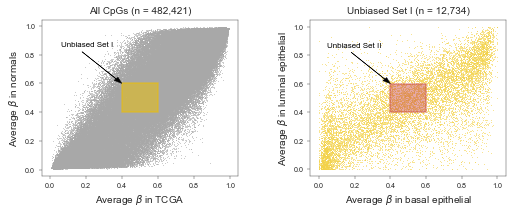

In [69]:
## Figure 2A

# Plot tumor and normals mean beta of each site
# Highlight region of selected sites

fig, axes = plt.subplots(1, 2, figsize=figsize * [2, 1] * sf)
fig.tight_layout(w_pad=4)

########################################
############### Left plot ##############
########################################

# Plot data
sns.scatterplot(ax=axes[0], x=data['tumor']['beta_means'],
                y=data['normals']['beta_means'], s = 5 * sf**2,
                color=consts['palette_jco'][2], alpha=consts['opacity']
               )

# Customize figure
axes[0].set_xlabel('Average $β$ in TCGA', fontsize=consts['labelfontsize'] * sf)
axes[0].set_ylabel('Average $β$ in normals', fontsize=consts['labelfontsize'] * sf)
axes[0].set_title(f'All CpGs (n = {data["tumor"]["beta_means"].shape[0]:,})', fontsize=consts['labelfontsize'] * sf)
axes[0].tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Add highlighted region for unbiased sites
lower = 0.4
upper = 0.6
axes[0].fill([lower, upper, upper, lower], [lower, lower, upper, upper],
        color=consts['palette_jco'][1], alpha=0.5, lw=4 * sf)

# Add text and arrow labeling the highlighted region
axes[0].text(0.35, 0.85, 'Unbiased Set I',
        ha="right", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=consts['labelfontsize'] * 0.8 * sf)
axes[0].arrow(0.18, 0.82, 0.22, -0.22, color='black', length_includes_head=True, head_width=0.03, lw=0.5)

########################################
############### Right plot #############
########################################

# Get theoretical sites selected from first step (only using tumor and normals cohorts)
tumorNormals_criteria = local_util.CLOCK_CRITERIA.copy()
del tumorNormals_criteria['basal']
del tumorNormals_criteria['luminal']
tumorNormal_unbiased_CpGs = local_util.getCpG_list(data, tumorNormals_criteria, starting_CpG_list=None)

# Plot data
sns.scatterplot(ax=axes[1], x=data['basal']['beta_means'].loc[tumorNormal_unbiased_CpGs],
                y=data['luminal']['beta_means'].loc[tumorNormal_unbiased_CpGs], s = 5 * sf**2,
                color=consts['palette_jco'][1], alpha=consts['opacity']
               )

# Customize figure
axes[1].set_xlabel('Average $β$ in basal epithelial', fontsize=consts['labelfontsize'] * sf)
axes[1].set_ylabel('Average $β$ in luminal epithelial', fontsize=consts['labelfontsize'] * sf)
axes[1].set_title(f'Unbiased Set I (n = {tumorNormal_unbiased_CpGs.shape[0]:,})', fontsize=consts['labelfontsize'] * sf)
axes[1].tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Add highlighted region for unbiased sites
lower = 0.4
upper = 0.6
axes[1].fill([lower, upper, upper, lower], [lower, lower, upper, upper],
        color=consts['palette_jco'][3], alpha=0.5, lw=4 * sf)

# Add text and arrow labeling the highlighted region
axes[1].text(0.35, 0.85, 'Unbiased Set II',
        ha="right", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=consts['labelfontsize'] * 0.8 * sf)
axes[1].arrow(0.18, 0.82, 0.22, -0.22, color='black', length_includes_head=True, head_width=0.03, lw=0.5)

########################################
############### Save figure ############
fig.savefig(os.path.join(figure_outdir, 'Figure_2_AB.pdf'), format='pdf', pad_inches=0.1)

Starting with 482421 CpGs


/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


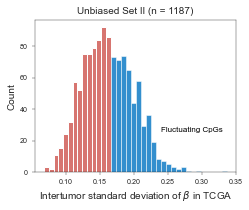

In [70]:
## Figure 1B

# Plot inter-tumor standard deviation of beta for each unbiased site
# Color blue the Clock sites selected (most variable sites)

# Generate the set of unbiased sites
balanced_means_CpGs = local_util.getCpG_list(data, local_util.CLOCK_CRITERIA, starting_CpG_list=None)

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)
sns.histplot(ax=ax,      # Non-fluctuating sites
             x=data['tumor']['beta_stds'].loc[balanced_means_CpGs[~np.isin(balanced_means_CpGs, Clock_CpGs_final_set)]],
             color=consts['palette_jco'][3], alpha=consts['opacity']
            )
sns.histplot(ax=ax,      # Fluctuating sites
             x=data['tumor']['beta_stds'].loc[Clock_CpGs_final_set],
             color=consts['palette_jco'][0], alpha=consts['opacity']
            )

# Customize figure
ax.set_xlabel('Intertumor standard deviation of $β$ in TCGA', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
ax.set_title(f'Unbiased Set II (n = {len(balanced_means_CpGs)})', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Label fluctuating sites
ax.text(0.24, 25, 'Fluctuating CpGs',
        ha="left", va="bottom", fontfamily='sans-serif', color='black',
        fontsize=consts['labelfontsize'] * 0.8 * sf)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'Figure_2_C.pdf'), format='pdf', pad_inches=0.1)

### Variance of normal vs tumor samples

In [3]:
## If you need to import these tables directly
import_Clock_beta_values = True

if import_Clock_beta_values:
    beta_values_Clock_TCGA = pd.read_table(
        os.path.join(consts['TCGA_datadir'], 'TCGA.methyl.Clock_revision.tsv'),
        index_col=0
    )
    beta_values_Clock_normals = pd.read_table(
        os.path.join(consts['official_indir'], 'Johnson', 'Johnson.methyl.Clock_revision.tsv'),
        index_col=0
    )

In [6]:
# Calculate s_beta for tumors
s_beta_tumors = beta_values_Clock_TCGA.std(axis=0)

# Calculate s_beta for normals
s_beta_normals = beta_values_Clock_normals.std(axis=0)

# Calculate wilcoxon rank-sums p-values
pvalue = epi_util.wilcoxonRankSums(s_beta_tumors, s_beta_normals).pvalue

print(f'Median standard deviation of clock beta values in TCGA tumors: {np.median(s_beta_tumors):.2f}')
print(f'Median standard deviation of clock beta values in normal breast samples: {np.median(s_beta_normals):.2f}')
print(f'Wilcoxon rank sum test: p = {pvalue:.0e}')

Median standard deviation of clock beta values in TCGA tumors: 0.19
Median standard deviation of clock beta values in normal breast samples: 0.08
Wilcoxon rank sum test: p = 3e-45


In [7]:
# Calculate site stdevs for tumors
site_stdevs_tumors = beta_values_Clock_TCGA.std(axis=1)

# Calculate site stdevs for normals
site_stdevs_normals = beta_values_Clock_normals.std(axis=1)

# Calculate wilcoxon rank-sums p-values
pvalue = epi_util.wilcoxonRankSums(site_stdevs_tumors, site_stdevs_normals).pvalue

print(f'Median standard deviation of TCGA beta values fo each Clock fCpG: {np.median(site_stdevs_tumors):.2f}')
print(f'Median standard deviation of normals beta values fo each Clock fCpG: {np.median(site_stdevs_normals):.2f}')
print(f'Wilcoxon rank sum test: p = {pvalue:.0e}')

Median standard deviation of TCGA beta values fo each Clock fCpG: 0.19
Median standard deviation of normals beta values fo each Clock fCpG: 0.06
Wilcoxon rank sum test: p = 6e-163


### One kernel per tumor/normal sample

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danielmonyak/opt/anaconda3/lib/python3.9/sit

color
#0073C2FF    633
#EFC000FF     79
Name: count, dtype: int64

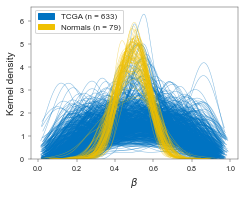

In [76]:
# Create plot
fig, ax = plt.subplots(figsize=figsize * [1.03, 1] * sf)

# Plot data

color_dict = {'TCGA':consts['palette_jco'][0], 'Normals':consts['palette_jco'][1]}

normals_plot_data = pd.melt(beta_values_Clock_normals[data['normals']['pureSamples']])
normals_plot_data['color'] = color_dict['Normals']
tumors_plot_data = pd.melt(beta_values_Clock_TCGA.loc[:, beta_values_Clock_TCGA.columns.isin(data['tumor']['pureSamples'])])
tumors_plot_data['color'] = color_dict['TCGA']

combined_plot_data = pd.concat([normals_plot_data, tumors_plot_data], axis=0).reset_index()


color_df = combined_plot_data[['variable', 'color']].drop_duplicates().set_index('variable')['color']
sns.kdeplot(ax=ax, data=combined_plot_data,
            x='value', lw=0.5, alpha=0.5,
            hue='variable',
            palette=color_df.to_dict(),
            legend=False, common_norm=False, cut=0)

display(color_df.value_counts())

# Customize figure
ax.set_xlabel('$β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel("Kernel density", fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Legend
patches = [mpatches.Patch(color=color_dict[group],
                          label=f"{group} (n = {color_df.value_counts().loc[color_dict[group]]})"
                         ) for group in color_dict.keys()]
# plots_x, plots_y = ax.get_position().get_points()[0]
pts = ax.get_position().get_points()
plots_x, plots_y = pts[0, 0], pts[1, 1]
fig.legend(handles=patches,
           loc='upper left',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8 * consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'KDE spaghetti plot.pdf'), format='pdf', pad_inches=0.1)

### One kernel per fCpG site

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danielmonyak/opt/anaconda3/lib/python3.9/sit

color
#0073C2FF    500
#EFC000FF    500
Name: count, dtype: int64

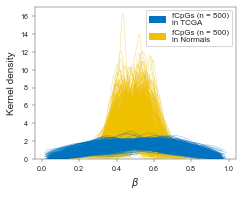

In [81]:
# Create plot
fig, ax = plt.subplots(figsize=figsize * sf)

# Plot data

color_dict = {'TCGA':consts['palette_jco'][0], 'Normals':consts['palette_jco'][1]}

normals_plot_data = pd.melt(beta_values_Clock_normals[data['normals']['pureSamples']].T).rename(columns={'ID_REF':'variable'})
normals_plot_data['color'] = color_dict['Normals']
normals_plot_data['variable'] = normals_plot_data['variable'] + '_Normals' # Identify these rows as normals data
tumors_plot_data = pd.melt(beta_values_Clock_TCGA.loc[:, beta_values_Clock_TCGA.columns.isin(data['tumor']['pureSamples'])].T)
tumors_plot_data['color'] = color_dict['TCGA']
tumors_plot_data['variable'] = tumors_plot_data['variable'] + '_TCGA' # Identify these rows as TCGA data


# combined_plot_data = pd.concat([normals_plot_data, tumors_plot_data], axis=0).reset_index()
combined_plot_data = pd.concat([tumors_plot_data, normals_plot_data], axis=0).reset_index()

color_df = combined_plot_data[['variable', 'color']].drop_duplicates().set_index('variable')['color']
sns.kdeplot(ax=ax, data=combined_plot_data,
            x='value', lw=0.5, alpha=0.5,
            hue='variable',
            palette=color_df.to_dict(),
            legend=False, common_norm=False, cut=0)

display(color_df.value_counts())

# Customize figure
ax.set_xlabel('$β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel("Kernel density", fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Legend
patches = [mpatches.Patch(color=color_dict[group], label=f'fCpGs (n = {color_df.value_counts().loc[color_dict[group]]})\nin {group}') for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(plots_x, plots_y + .005),
           fontsize=0.8 * consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'KDE spaghetti plot - one curve per fCpg.pdf'), format='pdf', pad_inches=0.1)

## Loyfer Normals

In [10]:
loyfer_indir = os.path.join(consts['official_indir'], 'Loyfer')

beta_values_cells = {}
cell_types = ['Adipocytes', 'Endothelium', 'Fibroblasts',
             'T-CD4', 'T-CD8', 'NK', 'B-cells', 'Monocytes', 'Macrophages']
for ct in cell_types:
    beta_values_cells[ct] = pd.read_table(os.path.join(loyfer_indir, f'beta_values-{ct}.tsv'), index_col=0)

In [20]:
', '.join(cell_types)

'Adipocytes, Endothelium, Fibroblasts, T-CD4, T-CD8, NK, B-cells, Monocytes, Macrophages'

In [11]:
beta_means_loyfer = pd.concat([beta_values_cells[ct].mean(axis=1).rename(ct) for ct in cell_types], axis=1)
Clock_CpGs = np.loadtxt(os.path.join(consts['repo_dir'], '3. Select fCpGs', 'outputs_revision', 'Clock_CpGs.txt'), dtype=str)

Text(0.5, 1.0, 'Mean = 0.48, SD = 0.22')

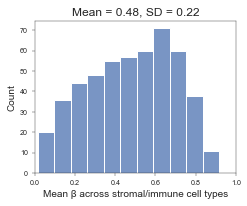

In [18]:
# Create plot
fig, ax = plt.subplots(figsize=figsize * sf)

inter_celltype_mean_beta_values = beta_means_loyfer.loc[Clock_CpGs].mean(axis=1)
sns.histplot(ax=ax, x=inter_celltype_mean_beta_values)


# Customize figure
ax.set_xlabel('Mean β across stromal/immune cell types', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_xlim(0, 1)

mean = inter_celltype_mean_beta_values.mean()
stdev = inter_celltype_mean_beta_values.std()
ax.set_title(f'Mean = {mean:.2f}, SD = {stdev:.2f}')

In [14]:
beta_means_loyfer.loc[Clock_CpGs].mean(axis=1).std()

0.21729348267017337

# Check ranking of fCpG variability in low and high purity tumors

In [10]:
Clock_CpGs = np.loadtxt(os.path.join(consts['repo_dir'], '3. Select fCpGs', 'outputs_revision', 'Clock_CpGs.txt'), dtype=str)
balanced_means_CpGs = np.loadtxt(os.path.join(output_dir, 'balanced_means_CpGs.txt'), dtype=str)

# Import clinical table
clinical = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.clinical.tsv'), index_col=0)
clinical = clinical.set_index('bcr_patient_barcode')

# Extract purity values from clinical table and sort by purity value
# Match sample IDs from beta value table to patient IDs in clinical table
patient_purity = clinical.loc[[epi_util.sampleToPatientID(x) for x in data['tumor']['pureSamples']], 'CPE']
sample_purity = pd.Series(index=data['tumor']['pureSamples'], data=patient_purity.values)
sample_purity = sample_purity.sort_values(ascending=True)

In [11]:
n_samps = sample_purity.shape[0]
n_samps_qtr = int(n_samps/4)
bottom_qtr_tumors = sample_purity.index[:n_samps_qtr].values
top_qtr_tumors = sample_purity.index[n_samps_qtr:].values

In [12]:
data['tumor']['beta_stds_bottomQtrTumors'] = data['tumor']['beta_values_SELECTION'][bottom_qtr_tumors].std(axis=1)
data['tumor']['beta_stds_topQtrTumors'] = data['tumor']['beta_values_SELECTION'][top_qtr_tumors].std(axis=1)

In [13]:
Clock_CpGs_bottomQtrTumors = local_util.getHighestRankedCpGs(data=data, n_select=500, sample_rank='tumor',
                                                             stat_rank='beta_stds_bottomQtrTumors',
                                                             good_end='higher', criteria_CpGs=balanced_means_CpGs)
Clock_CpGs_topQtrTumors = local_util.getHighestRankedCpGs(data=data, n_select=500, sample_rank='tumor',
                                                          stat_rank='beta_stds_topQtrTumors',
                                                          good_end='higher', criteria_CpGs=balanced_means_CpGs)

In [19]:
frac_in_bottomClock = np.intersect1d(Clock_CpGs, Clock_CpGs_bottomQtrTumors).shape[0] / 500
frac_in_topClock = np.intersect1d(Clock_CpGs, Clock_CpGs_topQtrTumors).shape[0] / 500
print(f'Fraction of Clock fCpGs that are still selected when only using the 25% least pure tumors: {frac_in_bottomClock}')
print(f'Fraction of Clock fCpGs that are still selected when only using the 25% most pure tumors: {frac_in_topClock}')

Fraction of Clock fCpGs that are still selected when only using the 25% least pure tumors: 0.912
Fraction of Clock fCpGs that are still selected when only using the 25% most pure tumors: 0.986
